# TBD Phase 2: Performance & Computing Models

## Introduction
In this lab, you will compare the performance and computing models of four popular data processing engines: **Polars, Pandas, DuckDB, and PySpark**.

You will explore:
- **Performance**: Single-node processing speed, parallel execution, and memory usage.
- **Scalability**: How performance changes with the number of cores (single-node) and executors (cluster).
- **Computing Models**: Out-of-core vs. In-memory processing, and Eager vs. Lazy execution.

### Engine Capabilities
The following table summarizes the key capabilities of the engines we will be testing. Use this as a reference.

| Engine | Query Optimizer | Distributed | Arrow-backed | Out-of-Core | Parallel | APIs | GPU Support |
|---|---|---|---|---|--|---|---|
| **Pandas** | ❌ | ❌ | optional ≥ 2.0 | ❌ | ❌ | DataFrame | ❌ |
| **Polars** | ✅ | ❌ | ✅ | ✅ | ✅ | DataFrame | ✅ (opt) |
| **PySpark** | ✅ | ✅ | Pandas UDF/IO | ✅ | ✅ | SQL, DataFrame | ❌ (no GPU) |
| **DuckDB** | ✅ | ❌ | ✅ | ✅ | ❌ | SQL, Relational API | ❌ |

## Prerequisites
Ensure you have the necessary libraries installed.

In [1]:
%pip install polars pandas duckdb pyspark faker deltalake memory_profiler pyarrow matplotlib

Note: you may need to restart the kernel to use updated packages.


In [54]:
import polars as pl
import pandas as pd
import duckdb
from pyspark.sql import SparkSession
from faker import Faker
import numpy as np
import os
import time
import psutil
from memory_profiler import memory_usage
# Initialize Spark (Single Node)

spark = SparkSession.getActiveSession()
if spark:
    spark.stop()
    print("Stopped existing Spark session.")
else:
    print("No active Spark session found.")
    


No active Spark session found.


## Part 1: Data Generation

We will generate a synthetic dataset simulating social media posts with a rich schema.

**Schema**:
- `post_id` (String): Unique identifier.
- `user_id` (Integer): User identifier.
- `timestamp` (DateTime): Time of post.
- `content` (String): Text content.
- `likes` (Integer): Number of likes.
- `views` (Integer): Number of views.
- `category` (String): Post category.
- `tags` (List[String]): Hashtags.
- `location` (String): User location.
- `device` (String): Device used (Mobile, Web, etc.).
- `latency` (Float): Network latency.
- `error_rate` (Float): Error rate during upload.

In [ ]:
def generate_data(num_records=1_000_000, output_path="social_media_data.parquet"):
    fake = Faker()
    
    print(f"Generating {num_records} records...")
    
    # Generate data using numpy for speed where possible
    data = {
        "post_id": [fake.uuid4() for _ in range(num_records)],
        "user_id": np.random.randint(1, 100_000, num_records),
        "timestamp": pd.date_range(start="2023-01-01", periods=num_records, freq="s").to_numpy().astype("datetime64[us]"),
        "likes": np.random.randint(0, 10_000, num_records),
        "views": np.random.randint(0, 1_000_000, num_records),
        "category": np.random.choice(["Tech", "Health", "Travel", "Food", "Fashion", "Politics", "Sports"], num_records),
        "tags": [np.random.choice(["#viral", "#new", "#trending", "#hot", "#update"], size=np.random.randint(1, 4)).tolist() for _ in range(num_records)],
        "location": np.random.choice(["USA", "UK", "DE", "PL", "FR", "JP", "BR"], num_records),
        "device": np.random.choice(["Mobile", "Desktop", "Tablet"], num_records),
        "latency": np.random.uniform(10.0, 500.0, num_records),
        "error_rate": np.random.beta(1, 10, num_records),
        "content": [fake.sentence() for _ in range(min(num_records, 1000))] * (num_records // 1000 + 1)
    }
    
    # Trim to exact size
    data["content"] = data["content"][:num_records]
    
    df = pd.DataFrame(data)
    
    print("Writing to Parquet...")
    df.to_parquet(output_path, engine="pyarrow")
    print(f"Data saved to {output_path}")

# Generate 5 million records
generate_data(num_records=5_000_000)

Generating 5000000 records...


## Part 2: Measuring Performance

### 2.1 Execution Time
Use `%time` or `%timeit` to measure execution time.

In [ ]:
# Example: Measuring time for all engines
print("--- Performance Benchmark Example ---")

# Pandas
print("Pandas Load Time:")
%time df_pd = pd.read_parquet("social_media_data.parquet")

# Polars
print("\nPolars Load Time:")
%time df_pl = pl.read_parquet("social_media_data.parquet")

# DuckDB
print("\nDuckDB Query Time:")
%time duckdb.sql("SELECT count(*) FROM 'social_media_data.parquet'").show()

# PySpark
print("\nSpark Load Time:")
# file_path = "gs://tbd-2025z-319020-dataproc-staging/data/social_media_data.parquet"
%time df_spark = spark.read.parquet("file:///social_media_data.parquet"); df_spark.count()

## Part 3: Student Tasks

### Task 1: Performance & Scalability (Single Node)

**Goal**: Benchmark the engines and test how they scale with available CPU cores.

**Instructions**:
1.  **Define Queries**: Create 3 distinct queries of your own choice. They should cover:
    -   **Query A**: A simple aggregation (e.g., grouping by a categorical column and calculating means).
    -   **Query B**: A window function or more complex transformation.
    -   **Query C**: A join (e.g., self-join or join with a smaller generated table) with filtering.
2.  **Benchmark**: Implement these queries in **Pandas, Polars, DuckDB, and PySpark**.
    -   Measure **Execution Time** using `%time` or `time.time()`.
    -   Measure **Peak Memory** usage using `memory_profiler` (e.g., `memory_usage()`).
3.  **Scalability Test**: 
    -   Select **all engines** that support parallel execution on a single node (e.g., Polars, DuckDB).
    -   Run **all 3 queries** with different numbers of threads/cores (e.g., 1, 2, 4, 8).
    -   Plot the speedup for each query and engine.

**Tip**: 
-   Polars: [polars.thread_pool_size](https://docs.pola.rs/api/python/stable/reference/api/polars.thread_pool_size.html) Please also note that *Thread configuration in Polars requires process restart*
-   DuckDB: `PRAGMA threads=n`
-   Spark: `master="local[n]"`

In [ ]:
# Task 1: Performance & Scalability (Single Node)

import matplotlib.pyplot as plt
from pyspark.sql import functions as F, Window

DATA_PATH = "social_media_data.parquet"
THREADS_TO_TEST = [1, 2, 4]

_dim_pd = pd.DataFrame({
    "category": ["Tech", "Health", "Travel", "Food", "Fashion", "Politics", "Sports"],
    "weight": [1.2, 0.9, 1.1, 1.0, 1.05, 0.95, 1.15]
})
_dim_pl = pl.from_pandas(_dim_pd)
_dim_spark = spark.createDataFrame(_dim_pd)

df_pd = pd.read_parquet(DATA_PATH)
df_pl = pl.read_parquet(DATA_PATH)
df_spark = spark.read.parquet(f"file:///{DATA_PATH}")

_duck = duckdb.connect()
_duck.execute(f"CREATE OR REPLACE TABLE posts AS SELECT * FROM '{DATA_PATH}'")
_duck.register("dim_category", _dim_pd)


def query_a_pd():
    return df_pd.groupby("category").agg({"likes": "mean", "views": "mean"})

def query_a_pl():
    return df_pl.group_by("category").agg([pl.col("likes").mean(), pl.col("views").mean()])

def query_a_duck():
    return _duck.execute("""
        SELECT category, avg(likes) AS avg_likes, avg(views) AS avg_views
        FROM posts
        GROUP BY category
    """).fetch_df()

def query_a_spark():
    return df_spark.groupBy("category").agg(F.avg("likes"), F.avg("views")).collect()


def query_b_pd():
    return (
        df_pd.sort_values("timestamp")
        .assign(
            likes_rank=df_pd.groupby("category")["likes"].rank(method="first"),
            views_dense_rank=df_pd.groupby("category")["views"].rank(method="dense"),
        )
        .head(100)
    )

def query_b_pl():
    return (
        df_pl.sort("timestamp")
        .with_columns([
            pl.col("likes").rank("ordinal").over("category").alias("likes_rank"),
            pl.col("views").rank("dense").over("category").alias("views_dense_rank"),
        ])
        .head(100)
    )

def query_b_duck():
    return _duck.execute("""
        SELECT category, timestamp, likes, views,
               rank() OVER (PARTITION BY category ORDER BY likes) AS likes_rank,
               dense_rank() OVER (PARTITION BY category ORDER BY views) AS views_dense_rank
        FROM posts
        ORDER BY timestamp
        LIMIT 100
    """).fetch_df()

def query_b_spark():
    return (
        df_spark
        .withColumn("likes_rank", F.rank().over(Window.partitionBy("category").orderBy("likes")))
        .withColumn("views_dense_rank", F.dense_rank().over(Window.partitionBy("category").orderBy("views")))
        .limit(100)
        .collect()
    )


def query_c_pd():
    return (
        df_pd.merge(_dim_pd, on="category")
        .query("views > 10000 and likes > 100")
        .groupby("category")
        .agg({"weight": "mean", "likes": "sum"})
    )


def query_c_pl():
    return (
        df_pl.join(_dim_pl, on="category")
        .filter((pl.col("views") > 10_000) & (pl.col("likes") > 100))
        .group_by("category")
        .agg([pl.col("weight").mean(), pl.col("likes").sum()])
    )


def query_c_duck():
    return _duck.execute("""
        SELECT p.category, avg(d.weight) AS avg_weight, sum(p.likes) AS total_likes
        FROM posts p
        JOIN dim_category d USING (category)
        WHERE p.views > 10000 AND p.likes > 100
        GROUP BY p.category
    """).fetch_df()


def query_c_spark():
    return (
        df_spark.join(_dim_spark, on="category")
        .filter((F.col("views") > 10000) & (F.col("likes") > 100))
        .groupBy("category")
        .agg(F.avg("weight"), F.sum("likes"))
        .collect()
    )

QUERIES = {
    "QueryA": {"pandas": query_a_pd, "polars": query_a_pl, "duckdb": query_a_duck, "spark": query_a_spark},
    "QueryB": {"pandas": query_b_pd, "polars": query_b_pl, "duckdb": query_b_duck, "spark": query_b_spark},
    "QueryC": {"pandas": query_c_pd, "polars": query_c_pl, "duckdb": query_c_duck, "spark": query_c_spark},
}

# ------------------ Benchmark helpers ------------------

def _bench(run_fn):
    t0 = time.time()
    mem_trace, _ = memory_usage((run_fn, (), {}), retval=True, include_children=True, max_iterations=1)
    elapsed = time.time() - t0
    return elapsed, max(mem_trace)


def _set_duck_threads(n):
    _duck.execute(f"PRAGMA threads={n}")


def _rebuild_spark(n):
    global spark, df_spark
    spark.stop()
    spark = SparkSession.builder.appName("BigDataLab2").master(f"local[{n}]").config("spark.driver.memory", "4g").getOrCreate()
    df_spark = spark.read.parquet(DATA_PATH)


results = []

for engine in ["pandas", "polars", "duckdb", "spark"]:
    thread_options = THREADS_TO_TEST if engine in ("duckdb", "spark") else [None]
    for threads in thread_options:
        if engine == "duckdb":
            _set_duck_threads(threads)
        if engine == "spark":
            _rebuild_spark(threads)
        for qname, registry in QUERIES.items():
            fn = registry[engine]
            elapsed, peak_mem = _bench(fn)
            results.append({
                "engine": engine,
                "threads": threads or 1,
                "query": qname,
                "time_s": round(elapsed, 3),
                "peak_mb": round(peak_mem, 2),
            })
            print(f"{engine} | {qname} | threads={threads or 1} | time={elapsed:.3f}s | peak_mb={peak_mem:.2f}")

benchmark_df = pd.DataFrame(results)
benchmark_df

# ------------------ Speedup plot ------------------
plot_df = benchmark_df[benchmark_df["threads"] >= 1]
fig, ax = plt.subplots(figsize=(8, 5))
for (engine, query), grp in plot_df.groupby(["engine", "query"]):
    base = grp.loc[grp["threads"] == grp["threads"].min(), "time_s"].iloc[0]
    ax.plot(grp["threads"], base / grp["time_s"], marker="o", label=f"{engine}-{query}")
ax.set_xlabel("Threads")
ax.set_ylabel("Speedup vs. 1 thread")
ax.set_xscale("log", base=2)
ax.set_title("Single-node speedup per query/engine")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(True)
plt.tight_layout()
plt.show()


### Task 2: Spark on Cluster

**Goal**: Compare Single Node performance vs. Spark on a Cluster.

**Instructions**:
1.  **Infrastructure**: Use the infrastructure from **Phase 1** (Google Dataproc). You may need to modify your Terraform code to adjust the cluster configuration (e.g., number of worker nodes).
2.  **Environment**: The easiest way to run this is via **Google Workbench** connected to your Dataproc cluster.
3.  **Upload Data**: Upload the generated `social_media_data.parquet` to HDFS or GCS.
    -   **Tip**: For better performance, consider **partitioning** the data (e.g., by `category` or `date`) when saving it to the distributed storage. This allows Spark to optimize reads.
4.  **Run Queries**: Run your PySpark queries from Task 1 on the cluster.
5.  **Scalability Test**: 
    -   Run the queries with different numbers of **worker nodes** (e.g., 2, 3, 4).
    -   You can achieve this by resizing the cluster (manually or via Terraform) or by configuring the number of executors in Spark.
6.  **Analyze**:
    -   How does the cluster performance compare to your local machine?
    -   Did adding more nodes/executors linearly improve performance?
    -   **Tip**: If Spark is slower than single-node engines, consider **increasing the dataset size** (e.g., generate 10M+ records or duplicate the data). Spark's overhead is significant for small data, and its true power appears when data exceeds single-node memory.

In [ ]:
spark.stop()

In [55]:
_dim_pd = pd.DataFrame({
    "category": ["Tech", "Health", "Travel", "Food", "Fashion", "Politics", "Sports"],
    "weight": [1.2, 0.9, 1.1, 1.0, 1.05, 0.95, 1.15]
})
def query_a_spark(df_spark):
    return df_spark.groupBy("category").agg(F.avg("likes"), F.avg("views")).collect()
def query_b_spark(df_spark):
    return (
        df_spark
        .withColumn("likes_rank", F.rank().over(Window.partitionBy("category").orderBy("likes")))
        .withColumn("views_dense_rank", F.dense_rank().over(Window.partitionBy("category").orderBy("views")))
        .limit(100)
        .collect()
    )
def query_c_spark(df_spark):
    return (
        df_spark.join(_dim_spark, on="category")
        .filter((F.col("views") > 10000) & (F.col("likes") > 100))
        .groupBy("category")
        .agg(F.avg("weight"), F.sum("likes"))
        .collect()
    )
QUERIES_SPARK = {
    "QueryA": {"spark": query_a_spark},
    "QueryB": {"spark": query_b_spark},
    "QueryC": {"spark": query_c_spark},
}

In [56]:
import time
import pandas as pd
from memory_profiler import memory_usage
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import functions as F, Window

def run_spark_cluster_benchmark(spark, exec_num, path):
    global _dim_spark

    df_spark = spark.read.parquet(path)
    _dim_spark = spark.createDataFrame(_dim_pd)

    def _bench(run_fn):
        t0 = time.time()
        mem_trace, _ = memory_usage((run_fn, (), {}), retval=True, include_children=True, max_iterations=1)
        elapsed = time.time() - t0
        return elapsed, max(mem_trace)
    
    results = []
    for qname, registry in QUERIES_SPARK.items():
        fn = registry["spark"]
        print(f"Running query {qname} on cluster...")
        elapsed, peak_mem = _bench(lambda: fn(df_spark))
        results.append({
            "query": qname,
            "time_s": round(elapsed, 3),
            "peak_mb": round(peak_mem, 2)
        })
        print(f"{qname} | time={elapsed:.3f}s | peak_mb={peak_mem:.2f}")

    benchmark_df = pd.DataFrame(results)
    display(benchmark_df)

    fig, ax = plt.subplots(figsize=(8,5))
    for query, grp in benchmark_df.groupby("query"):
        base = grp["time_s"].iloc[0]
        ax.bar(query, base)
    ax.set_ylabel("Time (s)")
    ax.set_title(f"PySpark cluster benchmark - {exec_num} executors")
    plt.xticks(rotation=45)
    plt.show()
    
    spark.stop()
    print("Spark session stopped.")

    return benchmark_df

In [ ]:
## Run with 2 executors

In [57]:
# 2 Executors
spark = (
    SparkSession.builder
    .appName("BigDataLab2-Cluster")
    .master("yarn")
    .config("spark.executor.instances", 2)
    .config("spark.dynamicAllocation.enabled", "true")
    .getOrCreate()
)

26/01/26 20:13:57 INFO SparkEnv: Registering MapOutputTracker
26/01/26 20:13:57 INFO SparkEnv: Registering BlockManagerMaster
26/01/26 20:13:57 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
26/01/26 20:13:57 INFO SparkEnv: Registering OutputCommitCoordinator


In [60]:
sc = spark._jsc.sc() 
for executor in sc.statusTracker().getExecutorInfos():
    print(executor.host())

tbd-cluster-m.c.tbd-2025z-319020.internal
tbd-cluster-w-0.c.tbd-2025z-319020.internal
tbd-cluster-w-1.c.tbd-2025z-319020.internal


Running query QueryA on cluster...


[Stage 1:============================================>              (3 + 1) / 4]

QueryA | time=9.325s | peak_mb=1433.89
Running query QueryB on cluster...


[Stage 6:>                                                          (0 + 1) / 1]

QueryB | time=20.860s | peak_mb=1441.54
Running query QueryC on cluster...


[Stage 11:=================================================>        (6 + 1) / 7]

QueryC | time=8.737s | peak_mb=1450.69


,query,time_s,peak_mb
0,QueryA,9.325,1433.89
1,QueryB,20.860,1441.54
2,QueryC,8.737,1450.69


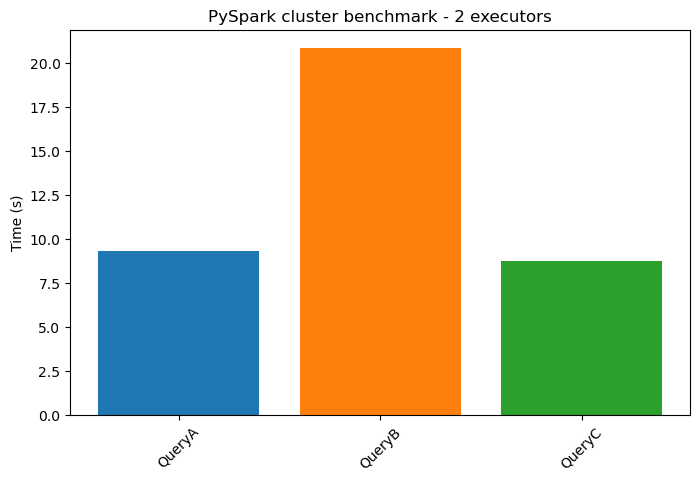

Spark session stopped.


In [61]:
try:
    run_spark_cluster_benchmark(spark, 2, DATA_PATH)
except:
    spark.stop()

In [ ]:
## 3 Executors

In [62]:
# 3 Executors
spark = (
    SparkSession.builder
    .appName("BigDataLab2-Cluster")
    .master("yarn")
    .config("spark.executor.instances", 3)
    .config("spark.dynamicAllocation.enabled", "true")
    .getOrCreate()
)

26/01/26 20:15:25 INFO SparkEnv: Registering MapOutputTracker
26/01/26 20:15:25 INFO SparkEnv: Registering BlockManagerMaster
26/01/26 20:15:25 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
26/01/26 20:15:25 INFO SparkEnv: Registering OutputCommitCoordinator


In [64]:
sc = spark._jsc.sc() 
for executor in sc.statusTracker().getExecutorInfos():
    print(executor.host())

tbd-cluster-m.c.tbd-2025z-319020.internal
tbd-cluster-w-0.c.tbd-2025z-319020.internal
tbd-cluster-w-1.c.tbd-2025z-319020.internal
tbd-cluster-w-0.c.tbd-2025z-319020.internal


[Stage 0:>                                                          (0 + 1) / 1]

Running query QueryA on cluster...


[Stage 1:=======================================>                   (4 + 2) / 6]

QueryA | time=10.408s | peak_mb=1465.28
Running query QueryB on cluster...


[Stage 6:>                                                          (0 + 1) / 1]

QueryB | time=18.060s | peak_mb=1467.39
Running query QueryC on cluster...


[Stage 11:========================>                                 (3 + 4) / 7]

QueryC | time=7.383s | peak_mb=1472.18


,query,time_s,peak_mb
0,QueryA,10.408,1465.28
1,QueryB,18.060,1467.39
2,QueryC,7.383,1472.18


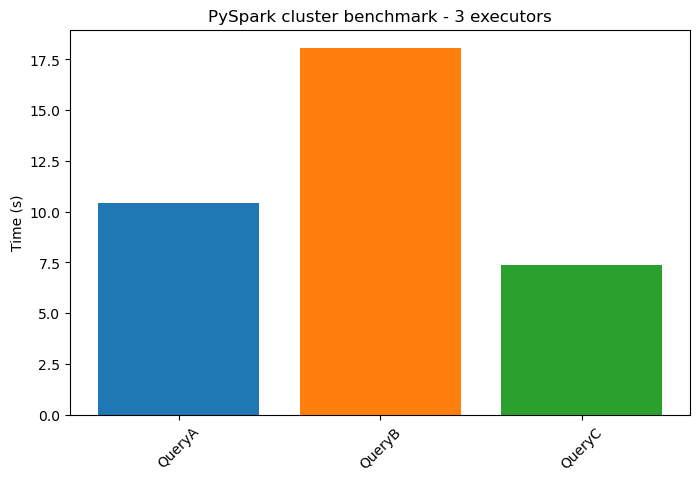

Spark session stopped.


In [65]:
try:
    run_spark_cluster_benchmark(spark, 3, DATA_PATH)
except:
    spark.stop()

In [ ]:
## 4 Executors

In [66]:
# 4 Executors
spark = (
    SparkSession.builder
    .appName("BigDataLab2-Cluster")
    .master("yarn")
    .config("spark.executor.instances", 4)
    .config("spark.dynamicAllocation.enabled", "true")
    .getOrCreate()
)

26/01/26 20:16:46 INFO SparkEnv: Registering MapOutputTracker
26/01/26 20:16:46 INFO SparkEnv: Registering BlockManagerMaster
26/01/26 20:16:46 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
26/01/26 20:16:46 INFO SparkEnv: Registering OutputCommitCoordinator


In [69]:
sc = spark._jsc.sc() 
for executor in sc.statusTracker().getExecutorInfos():
    print(executor.host())

tbd-cluster-m.c.tbd-2025z-319020.internal
tbd-cluster-w-0.c.tbd-2025z-319020.internal
tbd-cluster-w-1.c.tbd-2025z-319020.internal
tbd-cluster-w-0.c.tbd-2025z-319020.internal
tbd-cluster-w-1.c.tbd-2025z-319020.internal


[Stage 0:>                                                          (0 + 1) / 1]

Running query QueryA on cluster...


[Stage 1:============================================>              (6 + 2) / 8]

QueryA | time=9.124s | peak_mb=1474.71
Running query QueryB on cluster...


[Stage 6:>                                                          (0 + 1) / 1]

QueryB | time=18.306s | peak_mb=1478.34
Running query QueryC on cluster...


QueryC | time=9.780s | peak_mb=1480.90


,query,time_s,peak_mb
0,QueryA,9.124,1474.71
1,QueryB,18.306,1478.34
2,QueryC,9.780,1480.90


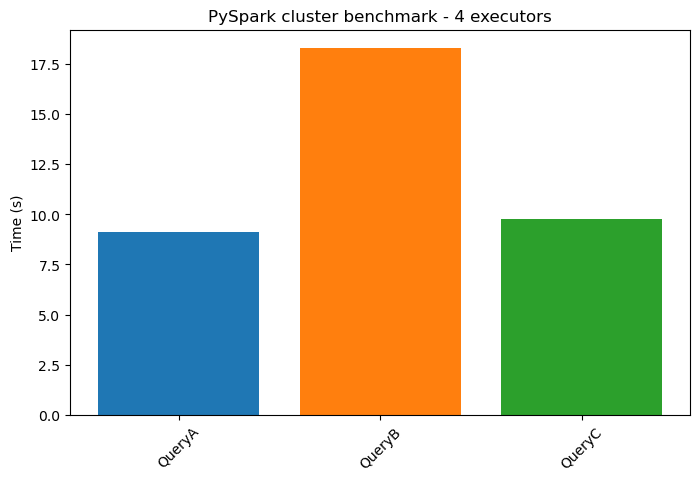

Spark session stopped.


In [70]:
try:
    run_spark_cluster_benchmark(spark, 4, DATA_PATH)
except:
    spark.stop()

In [ ]:
## Testing on Partitioned DATA

In [3]:
output_path = "gs://tbd-2025z-319020-dataproc-staging/social_media_data_partitioned/"
DATA_PATH = "gs://tbd-2025z-319020-dataproc-staging/social_media_data.parquet"

spark = SparkSession.builder.getOrCreate()

df_spark = spark.read.parquet(DATA_PATH)
df_doubled = df_spark.union(df_spark)

df_doubled.write \
    .mode("overwrite") \
    .partitionBy("category", "location") \
    .parquet(output_path)

In [ ]:
## TESTING 2 Executors

In [71]:
input_path = "gs://tbd-2025z-319020-dataproc-staging/social_media_data_partitioned/"

# 2 Executors
spark = (
    SparkSession.builder
    .appName("BigDataLab2-Cluster")
    .master("yarn")
    .config("spark.executor.instances", 2)
    .config("spark.dynamicAllocation.enabled", "true")
    .getOrCreate()
)

26/01/26 20:19:01 INFO SparkEnv: Registering MapOutputTracker
26/01/26 20:19:01 INFO SparkEnv: Registering BlockManagerMaster
26/01/26 20:19:01 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
26/01/26 20:19:01 INFO SparkEnv: Registering OutputCommitCoordinator


In [72]:
sc = spark._jsc.sc() 
for executor in sc.statusTracker().getExecutorInfos():
    print(executor.host())

tbd-cluster-m.c.tbd-2025z-319020.internal
tbd-cluster-w-1.c.tbd-2025z-319020.internal
tbd-cluster-w-0.c.tbd-2025z-319020.internal


[Stage 0:>                                                          (0 + 1) / 1]

Running query QueryA on cluster...


[Stage 1:=================================================>       (13 + 2) / 15]

QueryA | time=25.279s | peak_mb=1479.54
Running query QueryB on cluster...


[Stage 6:>                                                          (0 + 1) / 1]

QueryB | time=31.375s | peak_mb=1489.75
Running query QueryC on cluster...


[Stage 11:========================>                                 (3 + 4) / 7]

QueryC | time=15.471s | peak_mb=1485.56


,query,time_s,peak_mb
0,QueryA,25.279,1479.54
1,QueryB,31.375,1489.75
2,QueryC,15.471,1485.56


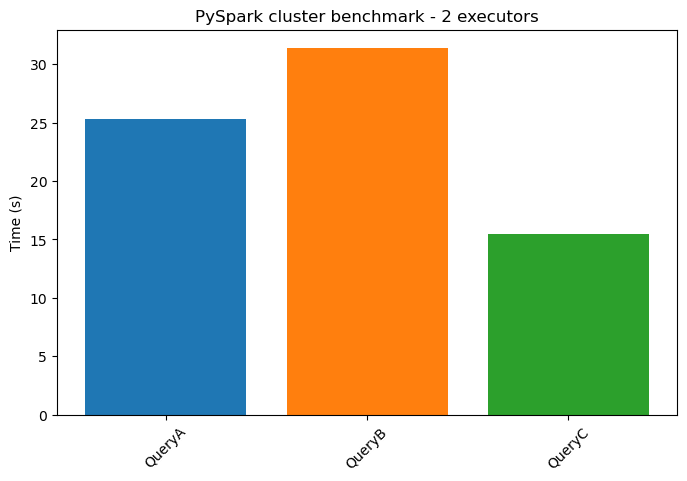

Spark session stopped.


In [73]:
try:
    run_spark_cluster_benchmark(spark, 2, input_path)
except:
    spark.stop()

In [ ]:
## TESTING 3 Executors

In [74]:
# 3 Executors
spark = (
    SparkSession.builder
    .appName("BigDataLab2-Cluster")
    .master("yarn")
    .config("spark.executor.instances", 3)
    .config("spark.dynamicAllocation.enabled", "true")
    .getOrCreate()
)

26/01/26 20:22:28 INFO SparkEnv: Registering MapOutputTracker
26/01/26 20:22:28 INFO SparkEnv: Registering BlockManagerMaster
26/01/26 20:22:28 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
26/01/26 20:22:28 INFO SparkEnv: Registering OutputCommitCoordinator


In [75]:
sc = spark._jsc.sc() 
for executor in sc.statusTracker().getExecutorInfos():
    print(executor.host())

tbd-cluster-m.c.tbd-2025z-319020.internal
tbd-cluster-w-1.c.tbd-2025z-319020.internal
tbd-cluster-w-0.c.tbd-2025z-319020.internal
tbd-cluster-w-1.c.tbd-2025z-319020.internal


[Stage 0:>                                                          (0 + 1) / 1]

Running query QueryA on cluster...


[Stage 1:=================================================>       (13 + 2) / 15]

QueryA | time=23.623s | peak_mb=1491.77
Running query QueryB on cluster...


[Stage 6:>                                                          (0 + 1) / 1]

QueryB | time=31.655s | peak_mb=1483.74
Running query QueryC on cluster...


QueryC | time=14.663s | peak_mb=1490.55


,query,time_s,peak_mb
0,QueryA,23.623,1491.77
1,QueryB,31.655,1483.74
2,QueryC,14.663,1490.55


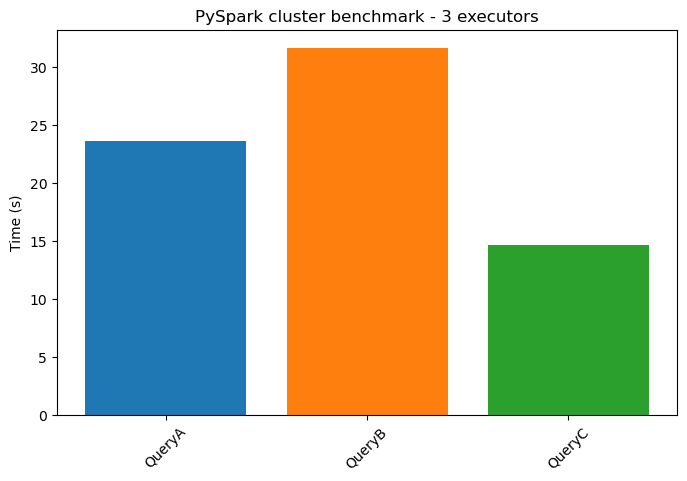

Spark session stopped.


In [76]:
try:
    run_spark_cluster_benchmark(spark, 3, input_path)
except:
    spark.stop()

In [ ]:
## TESTING 4 executors

In [77]:
# 4 Executors
spark = (
    SparkSession.builder
    .appName("BigDataLab2-Cluster")
    .master("yarn")
    .config("spark.executor.instances", 4)
    .config("spark.dynamicAllocation.enabled", "true")
    .getOrCreate()
)

26/01/26 20:24:42 INFO SparkEnv: Registering MapOutputTracker
26/01/26 20:24:42 INFO SparkEnv: Registering BlockManagerMaster
26/01/26 20:24:42 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
26/01/26 20:24:42 INFO SparkEnv: Registering OutputCommitCoordinator


In [79]:
sc = spark._jsc.sc() 
for executor in sc.statusTracker().getExecutorInfos():
    print(executor.host())

tbd-cluster-m.c.tbd-2025z-319020.internal
tbd-cluster-w-0.c.tbd-2025z-319020.internal
tbd-cluster-w-1.c.tbd-2025z-319020.internal
tbd-cluster-w-0.c.tbd-2025z-319020.internal
tbd-cluster-w-1.c.tbd-2025z-319020.internal


[Stage 0:>                                                          (0 + 1) / 1]

Running query QueryA on cluster...


[Stage 1:=====================================================>   (14 + 1) / 15]

QueryA | time=17.949s | peak_mb=1490.21
Running query QueryB on cluster...


[Stage 6:>                                                          (0 + 1) / 1]

QueryB | time=31.092s | peak_mb=1496.06
Running query QueryC on cluster...


[Stage 11:=========================================>                (5 + 2) / 7]

QueryC | time=14.429s | peak_mb=1493.48


,query,time_s,peak_mb
0,QueryA,17.949,1490.21
1,QueryB,31.092,1496.06
2,QueryC,14.429,1493.48


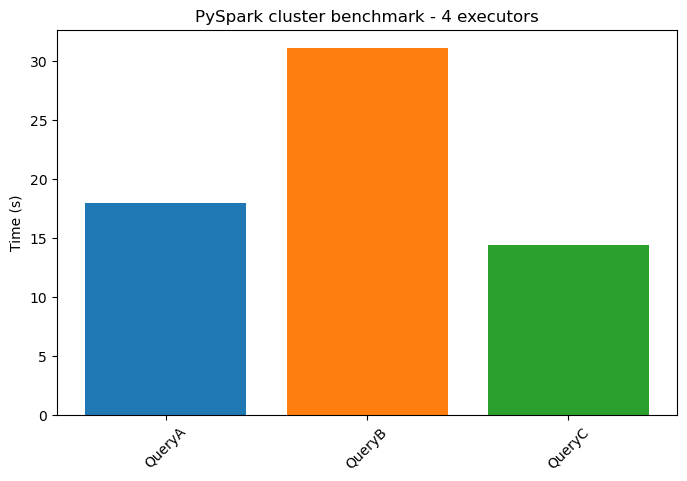

Spark session stopped.


In [80]:
try:
    run_spark_cluster_benchmark(spark, 4, input_path)
except:
    spark.stop()

### Task 3: Execution Modes & Analysis

**Goal**: Deep dive into execution models and limitations.

**Instructions**:
1.  **Lazy vs. Eager vs. Streaming**:
    -   Use **Polars**. Compare the **Execution Time** and **Peak Memory** of:
        -   Eager execution (`read_parquet` -> filter).
        -   Lazy execution (`scan_parquet` -> filter -> `collect()`).
        -   Streaming execution (`scan_parquet` -> filter -> `collect(streaming=True)`).
2.  **Polars Limitations**:
    -   Identify a scenario where Polars might struggle compared to Spark (e.g., memory limits).
3.  **Decision Boundary**:
    -   Based on your findings, when would you recommend switching from a single-node tool (Polars/DuckDB) to a distributed engine (Spark)?

In [ ]:
# Your Code Here for Task 3